### Skull Stripping
1. Create a BIDSDataGrabber Node
2. Create a Skull Stripping Node
3. Embed them into a workflow
4. Do the Scull Stripping of 3 subjects

In [140]:
from bids.grabbids import BIDSLayout


In [141]:
number_of_subjects = 3 # Number of subjects you wish to preprocess

In [142]:
layout = BIDSLayout("/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/")

Checking the Data directory Structure

In [143]:
!tree /home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/

/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/
├── participants.tsv
├── sub-0050952
│   ├── anat
│   │   └── sub-0050952_T1w.nii.gz
│   └── func
│       └── sub-0050952_task-rest_run-1_bold.nii.gz
├── sub-0050953
│   ├── anat
│   │   └── sub-0050953_T1w.nii.gz
│   └── func
│       └── sub-0050953_task-rest_run-1_bold.nii.gz
├── sub-0050954
│   ├── anat
│   │   └── sub-0050954_T1w.nii.gz
│   └── func
│       └── sub-0050954_task-rest_run-1_bold.nii.gz
├── sub-0050955
│   ├── anat
│   │   └── sub-0050955_T1w.nii.gz
│   └── func
│       └── sub-0050955_task-rest_run-1_bold.nii.gz
├── sub-0050956
│   ├── anat
│   │   └── sub-0050956_T1w.nii.gz
│   └── func
│       └── sub-0050956_task-rest_run-1_bold.nii.gz
├── sub-0050957
│   ├── anat
│   │   └── sub-0050957_T1w.nii.gz
│   └── func
│       └── sub-0050957_task-rest_run-1_bold.nii.gz
├── sub-0050958
│   ├── anat
│   │   └── sub-0050958_T1w.nii.gz
│   └── func
│       └── sub-0050958_task-rest_run-1_bold.nii.gz
├── sub-0050959
│   ├── an

In [144]:
layout.get_subjects(); # working!Gives us list of all the subjects

Create our own custom function - BIDSDataGrabber using a Function Interface.

In [145]:
def get_nifti_filenames(subject_id,data_dir):
#     Remember that all the necesary imports need to be INSIDE the function for the Function Interface to work!
    from bids.grabbids import BIDSLayout
    
    layout = BIDSLayout(data_dir)
    
    func_file_path = [f.filename for f in layout.get(subject=subject_id, type='bold', extensions=['nii', 'nii.gz'])]
    
    return func_file_path[0]

Wrap it inside a Node

In [146]:
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function

In [147]:
BIDSDataGrabber = Node(Function(function=get_nifti_filenames, input_names=['subject_id','data_dir'],
                                output_names='func_file_path'), name='BIDSDataGrabber')


In [148]:
# To test the function wrapped in the node

# BIDSDataGrabber.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
# BIDSDataGrabber.inputs.subject_id = '0050954'
# res = BIDSDataGrabber.run()

# res.outputs

Create Skull striping node

In [149]:
from nipype.interfaces.fsl import BET #,ExtractROI can be imported to ignore some brain volumes

In [150]:
skullStrip = Node(BET(mask=True),name='Brain_Extraction_Node') 

*Note*: Do not include special characters in ```name``` field above coz then  wf.writegraph will cause issues

In [151]:
# BET.help(); # Useful to see what are the parameters taken by BET

Create an IdentityInterface node to Distribute the subjects 

Create a list of subjects

In [152]:

subject_list = (layout.get_subjects())[0:3]

Create an IdentityInterface Node that helps us to iterate over all the subjects. In this type of node the inputs = outputs that's why its called an identity node. It has an aditional feature that it can iterate over the values a single field can take. In our case we tell it to iterate over field '`subject_id`' and take values given by `subject_list`

In [153]:
from nipype import IdentityInterface
infosource = Node(IdentityInterface(fields=['subject_id','data_dir']),
                  name="infosource")
infosource.inputs.data_dir = '/home/jovyan/work/preprocess/data/ABIDE-BIDS/NYU/'
infosource.iterables = [('subject_id', subject_list)]
# Note: Field 'data_dir' stays constant while the field'subject_id' takes on various values 
#       as there are multiple subjects

In [154]:
infosource.outputs # Checking the outputs of the above created node


data_dir = <undefined>
subject_id = <undefined>

In [155]:
# Create the workflow
wf = Workflow(name="BETFlow")
wf.base_dir = "/home/jovyan/work/preprocess/result" # Dir where all the outputs will be stored(inside BETFlow folder).

wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, skullStrip, [('func_file_path', 'in_file')])
                  ])
# Run it in parallel (one core for each smoothing kernel)
wf.run('MultiProc', plugin_args={'n_procs': 8})

170917-21:53:32,619 workflow INFO:
	 Workflow BETFlow settings: ['check', 'execution', 'logging']
170917-21:53:32,636 workflow INFO:
	 Running in parallel.
170917-21:53:32,641 workflow INFO:
	 Executing: BIDSDataGrabber.a1 ID: 0
170917-21:53:32,645 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.a1 jobid: 0
170917-21:53:32,647 workflow INFO:
	 Executing: BIDSDataGrabber.a0 ID: 1
170917-21:53:32,650 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.a0 jobid: 1
170917-21:53:32,652 workflow INFO:
	 Executing: BIDSDataGrabber.a2 ID: 3
170917-21:53:32,654 workflow INFO:
	 [Job finished] jobname: BIDSDataGrabber.a2 jobid: 3
170917-21:53:32,657 workflow INFO:
	 Executing: Brain_Extraction_Node.a0 ID: 2
170917-21:53:32,662 workflow INFO:
	 [Job finished] jobname: Brain_Extraction_Node.a0 jobid: 2
170917-21:53:32,664 workflow INFO:
	 Executing: Brain_Extraction_Node.a2 ID: 4
170917-21:53:32,669 workflow INFO:
	 [Job finished] jobname: Brain_Extraction_Node.a2 jobid: 4
170917-21:

### Summary:

170917-21:53:32,712 workflow INFO:
	 Creating detailed dot file: /home/jovyan/work/preprocess/result/BETFlow/graph_detailed.dot
170917-21:53:32,873 workflow INFO:
	 Creating dot file: /home/jovyan/work/preprocess/result/BETFlow/graph.dot


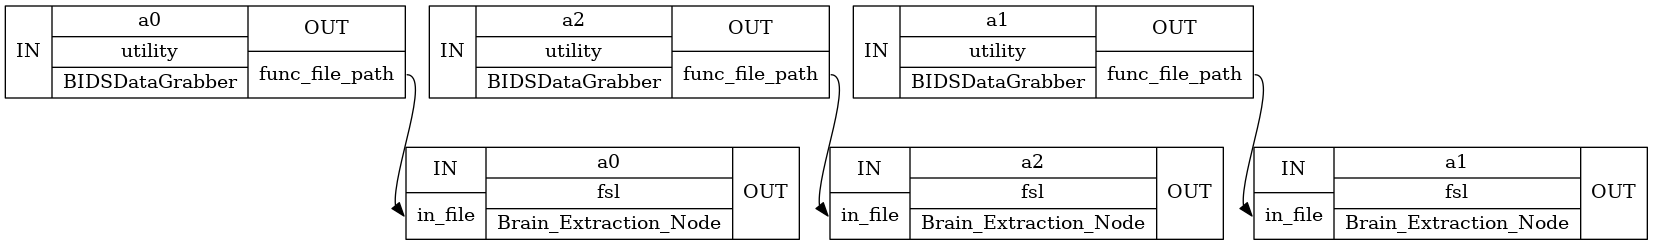

In [156]:
# Visualize the detailed graph
from IPython.display import Image
wf.write_graph(graph2use='exec', format='png', simple_form=True)

Image(filename='/home/jovyan/work/preprocess/result/BETFlow/graph_detailed.dot.png')


```
wf.connect([(infosource, BIDSDataGrabber, [('data_dir','data_dir'), ('subject_id', 'subject_id'),]),
                  (BIDSDataGrabber, skullStrip, [('func_file_path', 'in_file')])
                  ])
```

In the above created workflow the `infosource` node iterates over the `subject_id`, it creates a Node and for each Subject ID it sends `data_dir` (path where the data resides) and the subject specific `subject_id` to `BIDSDataGrabber` Node.

`BIDSDataGrabber` Node accepts the above 2 parameters, calls the function `get_nifti_filenames(subject_id,data_dir)`which returns the path of the BOLD file of the subject with given subject_id and hence the Node produces output that I call `func_file_path`.

This file path denoted by '``func_file_path``' is then fed as input to BET Node I named as `skullStrip` here, to get the extracted brain image in the directory : `/home/jovyan/work/preprocess/result/BETFlow`


